In [11]:
# read audio files
import librosa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Split Data Into Testing and Training

In [12]:
#split into 70 training and 30 testing for each emotion
import os
import random
import shutil

emotions = ['angry', 'fear', 'happy', 'sad']
train_ratio = 0.7

# #create a dataframe to hold the file paths and labels
# data_label = pd.DataFrame(columns=['filepath', 'label'])

#create train and test directories if they don't already exist
train_dir = 'train'
test_dir = 'test'
train_all_dir = 'train_all'
test_all_dir = 'test_all'
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(train_all_dir, exist_ok=True)
os.makedirs(test_all_dir, exist_ok=True)

for emotion in emotions:
    files = os.listdir(emotion)
    random.shuffle(files)
    split_index = int(train_ratio * len(files))
    train_files = files[:split_index]
    test_files = files[split_index:]
    
    #create emotion-specific train and test directories if they don't already exist
    emotion_train_dir = os.path.join(train_dir, emotion)
    emotion_test_dir = os.path.join(test_dir, emotion)
    os.makedirs(emotion_train_dir, exist_ok=True)
    os.makedirs(emotion_test_dir, exist_ok=True)
    
    #move files to emotion-specific train and test directories
    for file in train_files:
        src = os.path.join(emotion, file)
        dst = os.path.join(emotion_train_dir, file)
        shutil.copy(src, dst)
#         dst = os.path.join(train_all_dir, file)
#         shutil.copy(src, dst)
        
    for file in test_files:
        src = os.path.join(emotion, file)
        dst = os.path.join(emotion_test_dir, file)
        shutil.copy(src, dst)
#         dst = os.path.join(test_all_dir, file)
#         shutil.copy(src, dst)

In [3]:
emotions = ['angry', 'fear', 'happy', 'sad']
for emotion in emotions:
#print number of files in each directory
    total_files = len(files)
    num_train_files = len(train_files)
    num_test_files = len(test_files)
    print(f"{emotion}: total = {total_files}, train = {num_train_files}, test = {num_test_files}")

angry: total = 100, train = 70, test = 30
fear: total = 100, train = 70, test = 30
happy: total = 100, train = 70, test = 30
sad: total = 100, train = 70, test = 30


# Exploratory Data Analysis

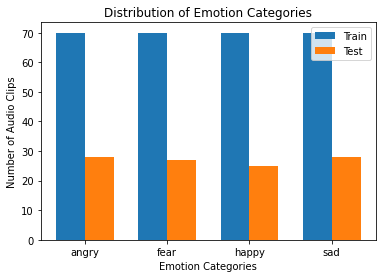

In [18]:
#bar chart to show distribution of labels
import os
import matplotlib.pyplot as plt
import numpy as np

emotions = ['angry', 'fear', 'happy', 'sad']
train_dir = 'train'
test_dir = 'test'

#count number of files in each emotion-specific train and test directories
train_files = []
test_files = []
for emotion in emotions:
    emotion_train_dir = os.path.join(train_dir, emotion)
    emotion_test_dir = os.path.join(test_dir, emotion)
    num_train_files = int(len(os.listdir(emotion_train_dir)) * 0.7)
    num_test_files = len(os.listdir(emotion_test_dir)) - num_train_files
    train_files.append(num_train_files)
    test_files.append(num_test_files)

#plot a bar chart of the number of train and test files for each emotion category
fig, ax = plt.subplots()
bar_width = 0.35
x_train = np.arange(len(emotions))
x_test = x_train + bar_width
train_bars = ax.bar(x_train, train_files, bar_width, label='Train')
test_bars = ax.bar(x_test, test_files, bar_width, label='Test')
ax.set_xticks(x_train + bar_width / 2)
ax.set_xticklabels(emotions)
ax.set_xlabel('Emotion Categories')
ax.set_ylabel('Number of Audio Clips')
ax.set_title('Distribution of Emotion Categories')
ax.legend()
plt.show()


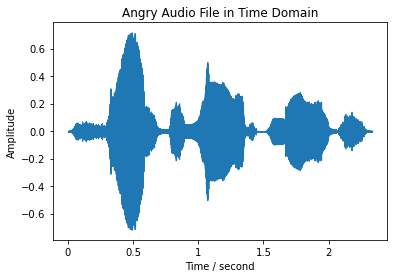

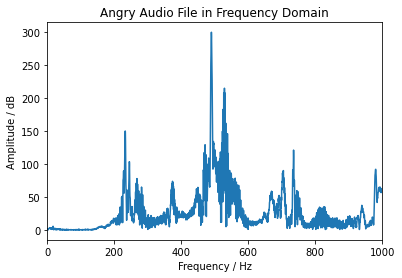

In [20]:
#check out sample audio
signal, sample_rate = librosa.load('./angry/YAF_merge_angry.wav')

# plot audio file in time domain
plt.figure(1)
librosa.display.waveshow(y=signal, sr=sample_rate)
plt.title('Angry Audio File in Time Domain')
plt.xlabel('Time / second')
plt.ylabel('Amplitude')
plt.show()

# plot audio files in frequency domain
k = np.arange(len(signal))
T = len(signal)/sample_rate
freq = k/T

DATA_0 = np.fft.fft(signal)
abs_DATA_0 = abs(DATA_0)
plt.figure(2)
plt.plot(freq, abs_DATA_0)
plt.title('Angry Audio File in Frequency Domain')

plt.xlabel("Frequency / Hz")
plt.ylabel("Amplitude / dB")
plt.xlim([0, 1000])
plt.show()

In [21]:
import wave
import pyaudio

filename = './angry/YAF_merge_angry.wav'

#open the audio file
wav_file = wave.open(filename, 'rb')

#create an instance of PyAudio
p = pyaudio.PyAudio()

#define callback function to stream audio data
def callback(in_data, frame_count, time_info, status):
    data = wav_file.readframes(frame_count)
    return (data, pyaudio.paContinue)

#open audio stream and start playback
stream = p.open(format=p.get_format_from_width(wav_file.getsampwidth()),
                channels=wav_file.getnchannels(),
                rate=wav_file.getframerate(),
                output=True,
                stream_callback=callback)

stream.start_stream()

#wait for playback to finish

while stream.is_active():
    continue

#stop stream and PyAudio instance
stream.stop_stream()
stream.close()
p.terminate()

#close the audio file
wav_file.close()

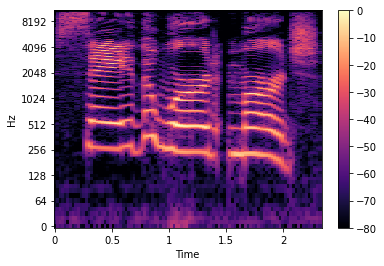

In [22]:
#plot the time-frequency variation of the audio
D = librosa.stft(signal)  # STFT of y
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
plt.figure(3)
librosa.display.specshow(S_db, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

# Acoustic Feature Extraction

In [13]:
# import os
# import pandas as pd
#set up features to extract

# audio feature extraction: loudness
def extract_loudness(signal):
    S, phase = librosa.magphase(librosa.stft(signal))
    rms = librosa.feature.rms(S=S)
    return rms[0]

# audio feature extraction: mel-frequency cepstral coefficients
def extract_mfccs(signal, sample_rate):
    mfccs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=12)
    return mfccs.T

# audio feature extraction: zero crossing rate
def extract_zero_crossing_rate(signal):
    zcr = librosa.feature.zero_crossing_rate(y=signal)
    return zcr[0]

# audio feature extraction: chroma
def extract_chroma(signal, sample_rate):
    chromagram = librosa.feature.chroma_stft(y=signal, sr=sample_rate)
    return chromagram.T

# audio feature extraction: mel spectrogram
def extract_mel_spectrogram(signal, sample_rate):
    mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sample_rate, n_mels=12)
    return mel_spectrogram.T

In [15]:
train_dir = './train_all' # directory path for training data
test_dir = './test_all' # directory path for testing data

# loop through training data directory and extract features for each file
train_data = pd.DataFrame()
for subdir, dirs, files in os.walk(train_dir):
    for file in files:
        file_path = os.path.join(subdir, file)
        signal, sample_rate = librosa.load(file_path)
        loudness = extract_loudness(signal)
        mfccs = extract_mfccs(signal, sample_rate)
        zcr = extract_zero_crossing_rate(signal)
        chroma = extract_chroma(signal, sample_rate)
        mel_spectrogram = extract_mel_spectrogram(signal, sample_rate)
        # extract emotion label from file name
        emotion = file.split('_')[-1].split('.')[0]
        # calculate the mean of each feature
        loudness_mean = np.mean(loudness)
        mfccs_mean = np.mean(mfccs)
        zcr_mean = np.mean(zcr)
        chroma_mean = np.mean(chroma)
        mel_spectrogram_mean = np.mean(mel_spectrogram)
        # create a dictionary to store the feature matrix and emotion label
        feature_dict = {'loudness': [loudness_mean], 'mfccs': [mfccs_mean], 'zcr': [zcr_mean], 'chroma': [chroma_mean], 'mel_spectrogram': [mel_spectrogram_mean], 'emotion': [emotion]}
        # convert dictionary to a DataFrame
        feature_matrix = pd.DataFrame(feature_dict)
        train_data = pd.concat([train_data, feature_matrix], axis=0)

# save feature matrix for training data as CSV
train_data.to_csv('./train_all_features.csv', index=False)

# loop through testing data directory and extract features for each file
test_data = pd.DataFrame()
for subdir, dirs, files in os.walk(test_dir):
    for file in files:
        file_path = os.path.join(subdir, file)
        signal, sample_rate = librosa.load(file_path)
        loudness = extract_loudness(signal)
        mfccs = extract_mfccs(signal, sample_rate)
        zcr = extract_zero_crossing_rate(signal)
        chroma = extract_chroma(signal, sample_rate)
        mel_spectrogram = extract_mel_spectrogram(signal, sample_rate)
        # extract emotion label from file name
        emotion = file.split('_')[-1].split('.')[0]
        # calculate the mean of each feature
        loudness_mean = np.mean(loudness)
        mfccs_mean = np.mean(mfccs)
        zcr_mean = np.mean(zcr)
        chroma_mean = np.mean(chroma)
        mel_spectrogram_mean = np.mean(mel_spectrogram)
        # create a dictionary to store the feature matrix and emotion label
        feature_dict = {'loudness': [loudness_mean], 'mfccs': [mfccs_mean], 'zcr': [zcr_mean], 'chroma': [chroma_mean], 'mel_spectrogram': [mel_spectrogram_mean], 'emotion': [emotion]}
        #convert dictionary to a DataFrame
        feature_matrix = pd.DataFrame(feature_dict)
        test_data = pd.concat([test_data, feature_matrix], axis=0)

# save feature matrix for training data as CSV
test_data.to_csv('./test_all_features.csv', index=False)


# Feature Post-Processing

In [29]:
import pandas as pd
import numpy as np

# Load train and test data
train_data = pd.read_csv('train_all_features.csv', dtype={'loudness': object, 'mfccs': object, 'zcr': object, 'chroma': object, 'mel_spectrogram': object})
test_data = pd.read_csv('test_all_features.csv', dtype={'loudness': object, 'mfccs': object, 'zcr': object, 'chroma': object, 'mel_spectrogram': object})

# # Define the time window in samples (assuming a sample rate of 44100 Hz)
# window_size = int(44100 * 0.1)

# Define the features to be scaled
features_to_scale = ['loudness', 'mfccs', 'zcr', 'chroma', 'mel_spectrogram']


# Convert the string representation of features to float arrays
for feature in features_to_scale:
    train_data[feature] = train_data[feature].apply(lambda x: np.array(x.strip('[]').split(), dtype=np.float32))
    test_data[feature] = test_data[feature].apply(lambda x: np.array(x.strip('[]').split(), dtype=np.float32))

# print(train_data.dtypes)
# print(test_data.dtypes)

# Scale the features to the range [-1, 1]
for feature in features_to_scale:
    # Calculate the min and max values across all the data (train and test)
    feature_min = min(train_data[feature].min(), test_data[feature].min())
    feature_max = max(train_data[feature].max(), test_data[feature].max())

    # Scale the feature to the range [-1, 1]
    train_data[feature] = 2 * (train_data[feature] - feature_min) / (feature_max - feature_min) - 1
    test_data[feature] = 2 * (test_data[feature] - feature_min) / (feature_max - feature_min) - 1

print(train_data)
print(test_data)
train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)

# save feature matrix for training data as CSV
train_data.to_csv('./train_processed.csv', index=False)
test_data.to_csv('./test_processed.csv', index=False)


          loudness          mfccs            zcr           chroma  \
0      [0.0981555]   [-0.8398185]  [0.026791215]     [-0.0368675]   
1      [-0.545087]  [-0.38663882]  [-0.21762562]    [-0.20705837]   
2    [-0.82673275]   [0.16946864]  [-0.72960734]    [-0.56861275]   
3     [-0.5048541]  [-0.64613867]    [0.6154777]  [-0.0055021048]   
4    [-0.55196744]   [0.41689634]   [0.56934416]     [0.08824623]   
..             ...            ...            ...              ...   
395  [-0.56860137]   [-0.3460253]   [0.70597136]   [-0.094851494]   
396  [-0.53100395]  [-0.75591826]   [0.64965665]    [-0.21284372]   
397   [-0.5644866]       [0.6244]   [-0.2819928]   [-0.043922365]   
398    [0.3085636]  [-0.22022223]  [-0.37763035]     [-0.9186202]   
399  [0.013902068]  [-0.44138318]   [0.13387942]    [-0.13669765]   

    mel_spectrogram emotion  
0      [-0.2481336]   angry  
1     [-0.74815005]    fear  
2      [-0.9322425]     sad  
3     [-0.77908516]   angry  
4      [-0.7059294]  

# Build Audio Emotion Recognition Model

In [30]:
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc, classification_report
svc = SVC(probability=True, max_iter = 10000)
nbcg = GaussianNB()
rfc = RandomForestClassifier()
knn = KNeighborsClassifier(n_neighbors=5)

In [53]:
# Load train and test data
train_data = pd.read_csv('train_processed.csv')
test_data = pd.read_csv('test_processed.csv')


# Define the features
features_to_scale = ['loudness', 'mfccs', 'zcr', 'chroma', 'mel_spectrogram']

# Convert the string representation of features to float arrays
for feature in features_to_scale:
    train_data[feature] = train_data[feature].str.strip(']').str.replace('\[', '').astype(float)
    test_data[feature] = test_data[feature].str.strip(']').str.replace('\[', '').astype(float)

# print(train_data)
train_X = train_data.loc[:, train_data.columns != "emotion"]
test_X = test_data.loc[:, test_data.columns != "emotion"]
train_Y = train_data.iloc[:,-1:]
test_Y = test_data.iloc[:,-1:]
# print(train_X)
    
# SVM
svc.fit(train_X, train_Y)
predicted = svc.predict(test_X)
print('SVM \n', classification_report(predicted, test_Y))

# NB
nbcg.fit(train_X, train_Y)
predicted = nbcg.predict(test_X)
print('Gaussian NB \n', classification_report(predicted, test_Y))

# RFC
rfc.fit(train_X, train_Y)
predicted = rfc.predict(test_X)
print('Random Forest Classifier \n', classification_report(predicted, test_Y))

# KNN
knn.fit(train_X, train_Y)
predicted = knn.predict(test_X)
print('KNN \n', classification_report(predicted, test_Y))


C:\Users\Maria\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Maria\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
<ipython-input-53-9fa2daed0bd5>:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(train_X, train_Y)


SVM 
               precision    recall  f1-score   support

       angry       0.92      0.84      0.88        99
        fear       0.81      0.91      0.86        82
       happy       0.89      0.91      0.90        90
         sad       1.00      0.96      0.98        98

    accuracy                           0.91       369
   macro avg       0.90      0.91      0.90       369
weighted avg       0.91      0.91      0.91       369

Gaussian NB 
               precision    recall  f1-score   support

       angry       0.89      0.73      0.80       109
        fear       0.62      0.81      0.70        72
       happy       0.86      0.85      0.85        93
         sad       0.95      0.94      0.94        95

    accuracy                           0.83       369
   macro avg       0.83      0.83      0.83       369
weighted avg       0.84      0.83      0.83       369

Random Forest Classifier 
               precision    recall  f1-score   support

       angry       1.00     

<ipython-input-53-9fa2daed0bd5>:43: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(train_X, train_Y)


In [70]:
# Will now analyze performance with best model (RFC) using different features
# Load train and test data
train_data = pd.read_csv('train_processed.csv')
test_data = pd.read_csv('test_processed.csv')

# Define the features
features_to_scale = ['loudness', 'mfccs', 'zcr', 'chroma', 'mel_spectrogram']

# Convert the string representation of features to float arrays
for feature in features_to_scale:
    train_data[feature] = train_data[feature].str.strip(']').str.replace('\[', '').astype(float)
    test_data[feature] = test_data[feature].str.strip(']').str.replace('\[', '').astype(float)

# test ONLY loudness
train_X = train_data.iloc[:,0]
test_X = test_data.iloc[:,0]
train_Y = train_data.iloc[:,-1:]
test_Y = test_data.iloc[:,-1:]
# print(train_X)
# print(test_X)

# SVM
svc.fit(train_X.values.reshape(-1, 1), train_Y)
predicted = svc.predict(test_X.values.reshape(-1,1))
print('SVM with Loudness Feature \n', classification_report(predicted, test_Y))


# test ONLY mfccs
train_X = train_data.iloc[:,1]
test_X = test_data.iloc[:,1]
train_Y = train_data.iloc[:,-1:]
test_Y = test_data.iloc[:,-1:]
# print(train_X)
# print(test_X)

# SVM
svc.fit(train_X.values.reshape(-1, 1), train_Y)
predicted = svc.predict(test_X.values.reshape(-1,1))
print('SVM with mfccs Feature \n', classification_report(predicted, test_Y))



# test ONLY zcr
train_X = train_data.iloc[:,2]
test_X = test_data.iloc[:,2]
train_Y = train_data.iloc[:,-1:]
test_Y = test_data.iloc[:,-1:]
# print(train_X)
# print(test_X)

# SVM
svc.fit(train_X.values.reshape(-1, 1), train_Y)
predicted = svc.predict(test_X.values.reshape(-1,1))
print('SVM with zcr Feature \n', classification_report(predicted, test_Y))


# test ONLY chroma
train_X = train_data.iloc[:,3]
test_X = test_data.iloc[:,3]
train_Y = train_data.iloc[:,-1:]
test_Y = test_data.iloc[:,-1:]
# print(train_X)
# print(test_X)

# SVM
svc.fit(train_X.values.reshape(-1, 1), train_Y)
predicted = svc.predict(test_X.values.reshape(-1,1))
print('SVM with chroma Feature \n', classification_report(predicted, test_Y))



# test ONLY mel spectrogram
train_X = train_data.iloc[:,4]
test_X = test_data.iloc[:,4]
train_Y = train_data.iloc[:,-1:]
test_Y = test_data.iloc[:,-1:]
# print(train_X)
# print(test_X)

# SVM
svc.fit(train_X.values.reshape(-1, 1), train_Y)
predicted = svc.predict(test_X.values.reshape(-1,1))
print('SVM with mel spectrogram Feature \n', classification_report(predicted, test_Y))

SVM with Loudness Feature 
               precision    recall  f1-score   support

       angry       0.77      0.40      0.53       171
        fear       0.00      0.00      0.00         0
       happy       0.78      0.79      0.79        91
         sad       0.80      0.70      0.75       107

    accuracy                           0.59       369
   macro avg       0.59      0.47      0.52       369
weighted avg       0.78      0.59      0.66       369

SVM with mfccs Feature 
               precision    recall  f1-score   support

       angry       0.89      0.74      0.81       108
        fear       0.01      0.25      0.02         4
       happy       0.62      0.49      0.55       116
         sad       0.82      0.55      0.66       141

    accuracy                           0.58       369
   macro avg       0.58      0.51      0.51       369
weighted avg       0.77      0.58      0.66       369

SVM with zcr Feature 
               precision    recall  f1-score   support


C:\Users\Maria\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Maria\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Maria\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Maria\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to 